# Tensorflow.keras implementation of one-bit-per-weight CNN for CIFAR 10 
##  https://arxiv.org/abs/1802.08530
## M. D. McDonnell, 
## Training wide residual networks for deployment using a single bit for each weight
## ICLR, 2018

In [1]:
# select a GPU
import os
os.environ["CUDA_DEVICE_ORDER"] = 'PCI_BUS_ID'
os.environ["CUDA_VISIBLE_DEVICES"] = '5'

import numpy as np
import h5py
import matplotlib.pyplot as plt
import copy
from scipy.io import savemat,loadmat
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)

import tensorflow
print('Tensorflow version = ',tensorflow.__version__)
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import LearningRateScheduler, History

#from tensorflow.keras import backend as K

from ResNetModel import resnet
from Utils import cutout,LR_WarmRestart,GetDataGen,plot_history

Tensorflow version =  1.13.1


In [9]:
#params
WhichDataSet = 'CIFAR10'
#WhichDataSet = 'CIFAR100'
init_lr = 0.1
epochs = 14#254
batch_size = 125
My_wd=5e-4/2
resnet_width = 10
resnet_depth = 20
UseBinary=True
UseCutout=True
Loss = 'categorical_crossentropy'
Optimizer = SGD(lr=init_lr,decay=0.0, momentum=0.9, nesterov=False)
Metrics = ['accuracy']
ModelsPath = 'TrainedModels/Tensorflow.keras/'

In [3]:
#load and prepare data
if WhichDataSet == 'CIFAR10':
    (x_train, y_train), (x_test, y_test) = tensorflow.keras.datasets.cifar10.load_data()
else:
    (x_train, y_train), (x_test, y_test) = tensorflow.keras.datasets.cifar100.load_data()
num_classes = np.unique(y_train).shape[0]
K_train = x_train.shape[0]
input_shape = x_train.shape[1:]
x_train = x_train.astype('float32')/255.0
x_test = x_test.astype('float32')/255.0
y_train = tensorflow.keras.utils.to_categorical(y_train, num_classes)
y_test = tensorflow.keras.utils.to_categorical(y_test, num_classes)


In [4]:
#fdefine a datagen or generating training samples with flip and pad/crop augmentation, and if set to True, with cutout augmentation
dataGenerator = GetDataGen(UseCutout)

#define and compile the model
model = resnet(UseBinary,input_shape=input_shape, depth=resnet_depth, num_classes=num_classes,wd=My_wd,width=resnet_width)
model.compile(loss=Loss ,optimizer = Optimizer, metrics = Metrics)

#print  the model
model.summary()

#define the learnng rate schedule
steps_per_epoch = int(np.floor(K_train / batch_size))
lr_scheduler = LR_WarmRestart(nbatch=steps_per_epoch,
                              initial_lr=init_lr, min_lr=init_lr*1e-4,
                              epochs_restart = [1.0,3.0, 7.0, 15.0, 31.0, 63.0,127.0,255.0]) 

#define callbacks
history = History()
callbacks = [lr_scheduler,history]

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 32, 32, 3)    12          input_1[0][0]                    
__________________________________________________________________________________________________
binary_conv2d (BinaryConv2D)    (None, 32, 32, 160)  4320        batch_normalization_v1[0][0]     
__________________________________________________________________________________________________
batch_normalization_v1_1 (Batch (None, 32, 32, 160)  320         binary_conv2d[0][0]              
__________________________________________________________________________________________________
activation

In [5]:
history = model.fit_generator(dataGenerator.flow(x_train, y_train, batch_size=batch_size),
                              validation_data=(x_test, y_test),
                              epochs=epochs,
                              verbose=1,
                              callbacks=callbacks,
                              steps_per_epoch =steps_per_epoch)

Instructions for updating:
Use tf.cast instead.

 Start of Epoch Learning Rate = 0.100000
Epoch 1/14
10000/10000 [==============================] - 7s 672us/sample - loss: 4.3489 - acc: 0.4179

 End of Epoch Learning Rate = 0.050005
400/400 [==============================] - 109s 273ms/step - loss: 4.5083 - acc: 0.4647 - val_loss: 4.3489 - val_acc: 0.4179

 Start of Epoch Learning Rate = 0.050005
Epoch 2/14
10000/10000 [==============================] - 6s 631us/sample - loss: 3.3768 - acc: 0.7002

 End of Epoch Learning Rate = 0.000010
400/400 [==============================] - 107s 267ms/step - loss: 3.6073 - acc: 0.6351 - val_loss: 3.3768 - val_acc: 0.7002

 Start of Epoch Learning Rate = 0.100000
Epoch 3/14
10000/10000 [==============================] - 6s 631us/sample - loss: 2.9521 - acc: 0.5973

 End of Epoch Learning Rate = 0.085357
400/400 [==============================] - 108s 269ms/step - loss: 3.2196 - acc: 0.6293 - val_loss: 2.9521 - val_acc: 0.5973

 Start of Epoch Learn

In [6]:
#get final performance
y_pred = model.predict(x_test)
print('Test accuracy (%):', 100*sum(np.argmax(y_pred,-1)==np.argmax(y_test,-1))/y_test.shape[0])

Test accuracy (%): 90.6


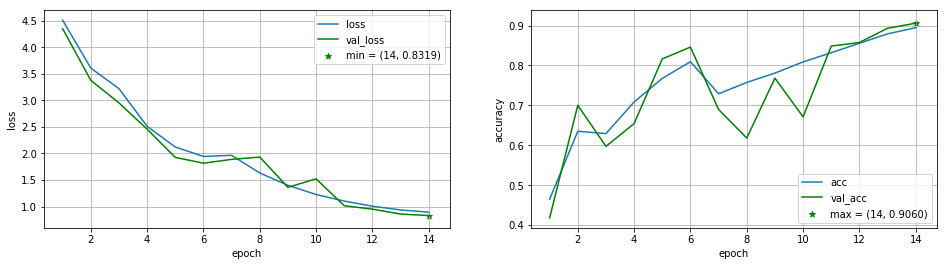

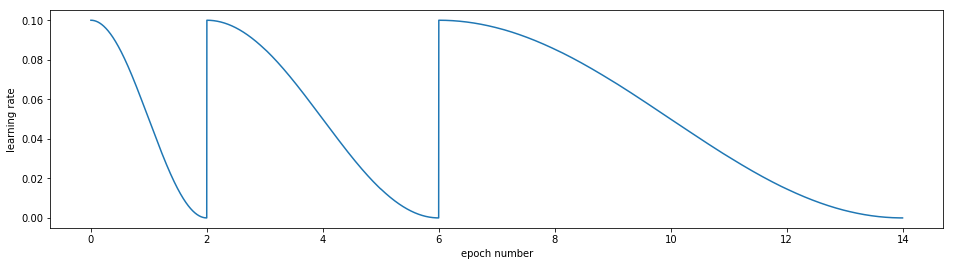

In [7]:
#plot loss and accuracy
plot_history(model.history.history)

#plot learning rate schedule
plt.figure(figsize=(16,4))
plt.plot(np.arange(0,len(lr_scheduler.lr_used))/steps_per_epoch,lr_scheduler.lr_used)
plt.xlabel('epoch number')
plt.ylabel('learning rate')
plt.show()

In [10]:
#save the weigts used for updating
model.save_weights(ModelsPath+'Final_weights_'+WhichDataSet+'_full_precision.h5')

In [12]:
#create an inference model that uses regular conv2d layers
inference_model = resnet(UseBinaryWeights=False,input_shape=input_shape, depth=resnet_depth, num_classes=num_classes,wd=My_wd,width=resnet_width)
inference_model.compile(loss=Loss ,optimizer = Optimizer, metrics = Metrics)
inference_model.load_weights(ModelsPath+'Final_weights_'+WhichDataSet+'_full_precision.h5')

#get accuracy:
y_pred = inference_model.predict(x_test)
print('Test accuracy (%):', 100*sum(np.argmax(y_pred,-1)==np.argmax(y_test,-1))/y_test.shape[0])

#doesn't work yet because sign and scale not yet applied, as we set UseBinaryWeights=False for inference_model

Test accuracy (%): 10.0


In [13]:
#convert weights to one bit storage in python and copy into the inference model

ZeroOneWeightsDict = {}
AllParamsDict={}
NumBinaryWeights=0.0
for layer in inference_model.layers:
    #print(layer.name)

    if 'conv2d' in layer.name:
        ww=layer.get_weights()
        layer.set_weights(np.sign(ww)*np.sqrt(2.0/np.prod(ww[0].shape[0:3])))
        
        #storage using 1 bit booleans
        binary_weights = (0.5*(np.sign(ww)+1.0)).astype('bool')
        ZeroOneWeightsDict[layer.name]=binary_weights
        AllParamsDict[layer.name]=binary_weights
        NumBinaryWeights+=np.prod(ww[0].shape)
    elif 'batch_normalization' in layer.name:
        #the saved model also nees floating point batch norm params
        ww=layer.get_weights()
        AllParamsDict[layer.name]=ww
        
savemat(ModelsPath+WhichDataSet+'_01weights.mat',ZeroOneWeightsDict,do_compression=True,long_field_names=True)
savemat(ModelsPath+WhichDataSet+'_allparams.mat',AllParamsDict,do_compression=True,long_field_names=True)
inference_model.save_weights(ModelsPath+'Final_weights_'+WhichDataSet+'_binarized.h5')

WeightsMemory=NumBinaryWeights/8/1024/1024
print('Num binary weights = ',int(NumBinaryWeights),'; weights memory = ',WeightsMemory,'  MB')

#get accuracy:
y_pred = inference_model.predict(x_test)
print('Test accuracy (%):', 100*sum(np.argmax(y_pred,-1)==np.argmax(y_test,-1))/y_test.shape[0])

Num binary weights =  26737120 ; weights memory =  3.1873130798339844   MB
Test accuracy (%): 90.6


In [14]:
#verify 1 bit weights work perfectly when loaded from h5 file

inference_model.load_weights(ModelsPath+'Final_weights_'+WhichDataSet+'_binarized.h5')

#verify each layer can take only two values:
cc=0
for layer in inference_model.layers:
    if 'conv2d' in layer.name:
        
        ww=layer.get_weights()
        uw = np.unique(ww)
        print('conv layer ',cc,' has ', len(uw),' unique weights')
        cc=cc+1

#get accuracy:
y_pred = inference_model.predict(x_test)
print('Test accuracy (%):', 100*sum(np.argmax(y_pred,-1)==np.argmax(y_test,-1))/y_test.shape[0])

conv layer  0  has  2  unique weights
conv layer  1  has  2  unique weights
conv layer  2  has  2  unique weights
conv layer  3  has  2  unique weights
conv layer  4  has  2  unique weights
conv layer  5  has  2  unique weights
conv layer  6  has  2  unique weights
conv layer  7  has  2  unique weights
conv layer  8  has  2  unique weights
conv layer  9  has  2  unique weights
conv layer  10  has  2  unique weights
conv layer  11  has  2  unique weights
conv layer  12  has  2  unique weights
conv layer  13  has  2  unique weights
conv layer  14  has  2  unique weights
conv layer  15  has  2  unique weights
conv layer  16  has  2  unique weights
conv layer  17  has  2  unique weights
conv layer  18  has  2  unique weights
conv layer  19  has  2  unique weights
Test accuracy (%): 90.6


In [15]:
#verify get the same results from compressed boolean storage
AllParamsDict_loaded=loadmat(ModelsPath+WhichDataSet+'_allparams.mat')


#verify each layer can take only two values:
#this requires layers saved with the same name as the most recently defined model
cc=0
for layer in inference_model.layers:
    if 'conv2d' in layer.name:
        ww=AllParamsDict_loaded[layer.name].astype('float32')*2.0-1.0
        ww=ww*np.sqrt(2.0/np.prod(ww[0].shape[0:3]))
        layer.set_weights([ww[0]])
        uw = np.unique(ww)
        print('conv layer ',cc,' has ', len(uw),' unique weights')
        cc=cc+1
    elif 'batch_normalization' in layer.name:
        #as a shortcut for this demo, note we already have the BN weights in the model
        #its a bit tedious wth .mat format to deal with the fact that BN layers can have a list of weights
        pass


#get accuracy:
y_pred = inference_model.predict(x_test)
print('Test accuracy (%):', 100*sum(np.argmax(y_pred,-1)==np.argmax(y_test,-1))/y_test.shape[0])

conv layer  0  has  2  unique weights
conv layer  1  has  2  unique weights
conv layer  2  has  2  unique weights
conv layer  3  has  2  unique weights
conv layer  4  has  2  unique weights
conv layer  5  has  2  unique weights
conv layer  6  has  2  unique weights
conv layer  7  has  2  unique weights
conv layer  8  has  2  unique weights
conv layer  9  has  2  unique weights
conv layer  10  has  2  unique weights
conv layer  11  has  2  unique weights
conv layer  12  has  2  unique weights
conv layer  13  has  2  unique weights
conv layer  14  has  2  unique weights
conv layer  15  has  2  unique weights
conv layer  16  has  2  unique weights
conv layer  17  has  2  unique weights
conv layer  18  has  2  unique weights
conv layer  19  has  2  unique weights
Test accuracy (%): 90.6
